# Chapter 6 - Linear Model Selection and Regularization

In [1]:
import numpy as np
import pandas as pd
from math import exp, log, sqrt, pi
import time
import itertools
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import scale, StandardScaler 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import os.path

## Lab 1: Subset Selection Model

In [2]:
url_path = os.path.abspath('..')
hitters = pd.read_csv(url_path + '\data\Hitters.csv', index_col=0)
hitters.index.name = 'Player'

In [3]:
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [4]:
hitters.dropna(axis=0, inplace=True)

In [5]:
hitters.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,403.642586,107.828897,11.619772,54.745247,51.486692,41.114068,7.311787,2657.543726,722.186312,69.239544,361.220532,330.418251,260.266160,290.711027,118.760456,8.593156,535.925882
std,147.307209,45.125326,8.757108,25.539816,25.882714,21.718056,4.793616,2286.582929,648.199644,82.197581,331.198571,323.367668,264.055868,279.934575,145.080577,6.606574,451.118681
min,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.000000,4.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,67.500000
25%,282.500000,71.500000,5.000000,33.500000,30.000000,23.000000,4.000000,842.500000,212.000000,15.000000,105.500000,95.000000,71.000000,113.500000,8.000000,3.000000,190.000000
50%,413.000000,103.000000,9.000000,52.000000,47.000000,37.000000,6.000000,1931.000000,516.000000,40.000000,250.000000,230.000000,174.000000,224.000000,45.000000,7.000000,425.000000
75%,526.000000,141.500000,18.000000,73.000000,71.000000,57.000000,10.000000,3890.500000,1054.000000,92.500000,497.500000,424.500000,328.500000,322.500000,192.000000,13.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.000000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1377.000000,492.000000,32.000000,2460.000000


In [6]:
def fit_linear_reg(X, y):
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rss =  mse * len(y)
    r_squared = model.score(X, y)
    return rss, r_squared, mse

def calculate_aic(num_obs, mse, num_params):
    '''
    AIC is derived from a frequentist framework.
    AIC cannot be interpreted as an approximation to the marginal likelihood.
    AIC penalizes complex models less than BIC.
    In general selects more complex models.
    
    '''
    
    aic = num_obs * log(mse) + 2 * num_params
    return aic

def calculate_bic(num_obs, mse, num_params):
    '''
    
    Bayesian method.
    Models fit under the MLE framework.
    If selected candidate models include a true model for the dataset...  
    then the probability that BIC will select the true model increases with the size of the training dataset
    '''
    bic = num_obs * log(mse) + num_params * log(num_obs)
    return bic

#### Commented out because requires loads of processing time.

In [7]:
"""
y = hitters['Salary']
X = hitters.drop(['League', 'Division', 'Salary', 'NewLeague'], axis=1)
rss_arr, r_sqrd_arr, feature_list = [], [], []
bic_arr, aic_arr = [], []
mse_arr =[]
num_features = []

for feature_idx in trange(1, len(X.columns)+1, desc='Looping...'):
    
    for permu in itertools.combinations(X.columns, feature_idx):
        tmp_rss, tmp_r_sqrd, tmp_mse = fit_linear_reg(X[list(permu)], y)
        rss_arr.append(tmp_rss)
        r_sqrd_arr.append(tmp_r_sqrd)
        mse_arr.append(tmp_mse)
        
        # information criterion metrics
        tmp_aic = calculate_aic(X.shape[0], tmp_mse, len(permu))
        aic_arr.append(tmp_aic)
        
        tmp_bic = calculate_bic(X.shape[0], tmp_mse, len(permu))
        bic_arr.append(tmp_bic)
        
        # record features
        feature_list.append(permu)
        num_features.append(len(permu))
        
"""

"\ny = hitters['Salary']\nX = hitters.drop(['League', 'Division', 'Salary', 'NewLeague'], axis=1)\nrss_arr, r_sqrd_arr, feature_list = [], [], []\nbic_arr, aic_arr = [], []\nmse_arr =[]\nnum_features = []\n\nfor feature_idx in trange(1, len(X.columns)+1, desc='Looping...'):\n    \n    for permu in itertools.combinations(X.columns, feature_idx):\n        tmp_rss, tmp_r_sqrd, tmp_mse = fit_linear_reg(X[list(permu)], y)\n        rss_arr.append(tmp_rss)\n        r_sqrd_arr.append(tmp_r_sqrd)\n        mse_arr.append(tmp_mse)\n        \n        # information criterion metrics\n        tmp_aic = calculate_aic(X.shape[0], tmp_mse, len(permu))\n        aic_arr.append(tmp_aic)\n        \n        tmp_bic = calculate_bic(X.shape[0], tmp_mse, len(permu))\n        bic_arr.append(tmp_bic)\n        \n        # record features\n        feature_list.append(permu)\n        num_features.append(len(permu))\n        \n"

In [8]:
df = pd.DataFrame({'num_features': num_features, 'RSS': rss_arr, 'R_Squared': r_sqrd_arr, 'features': feature_list,
                  'AIC': aic_arr, 'BIC': bic_arr})
df.sort_values('R_Squared', ascending=False, inplace=True)
df.head(10)

NameError: name 'num_features' is not defined

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 12))
sns.scatterplot(x='num_features', y='RSS', data=df, ax=axes[0])
sns.scatterplot(x='num_features', y='R_Squared', data=df, ax=axes[1])
sns.scatterplot(x='num_features', y='AIC', data=df, ax=axes[2])
sns.scatterplot(x='num_features', y='BIC', data=df, ax=axes[3])
fig.tight_layout();

## Lab 2: Ridge Regression and the Lasso

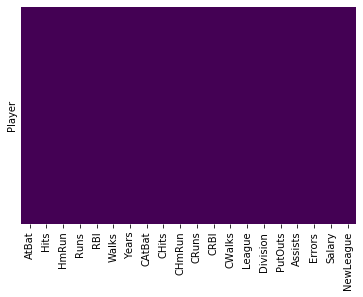

In [9]:
sns.heatmap(hitters.isnull(), cmap='viridis', cbar=False, yticklabels=False)

In [10]:
# Drop dependent and categorial variables.
X = hitters.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1)
y = hitters['Salary']


dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']])
X = pd.concat([X, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

The __sklearn Ridge()__ function optimizes:
$$ ||X\beta - y||^2_2 + \alpha ||\beta||^2_2 $$
which is equivalent to optimizing
$$ \frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 $$

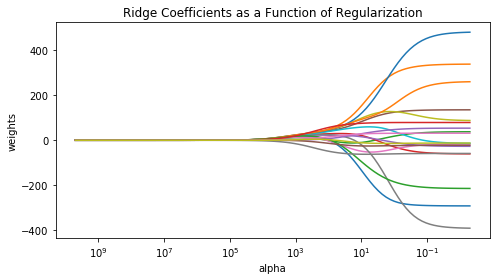

In [11]:
# alpha = lambda
# lambda is the strength of the regularizatin/shrinkage penalty.
# When lambda is 0, the penalty term has no effect. Ridge regression will produce the least squares estimate.
# As lambda increases, the impact of the shrinkage penalty grows and the rdige regression coefficients will approach zero.
alphas = 10**np.linspace(10, -2, 100)*0.5

ridge = Ridge()
coefs = []

# scale() = Center to the mean and component wise scale to unit variance.
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1]) #reverse axis
ax.set_xlabel('alpha')
ax.set_ylabel('weights')
ax.set_title('Ridge Coefficients as a Function of Regularization')
fig.tight_layout();

The above plot shows that as the value of alpha decreases, the Ridge coefficients' values increase.

In [12]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Unclear as to why JWarmenhoven enter this number
# ISLR used alpha = 4.
# Maybe b/c the optimization functions differ b/t Sklearn and R.
alpha = len(X)*(11498/2)

ridge2 = Ridge(alpha=alpha)
ridge2.fit(X_train_scaled, y_train)
y_pred = ridge2.predict(X_test_scaled)

print("MSE: ", mean_squared_error(y_test, y_pred))

MSE:  327518.77087389305


In [ ]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

<br>
<br>
This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [ ]:
alpha = 10 ** 10
ridge2.set_params(alpha=alpha)
ridge2.fit(X_train_scaled, y_train)
y_pred = ridge2.predict(X_test_scaled)

print("MSE: ", mean_squared_error(y_test, y_pred))

<br>
Identify the optimal value for alpha, i.e., lambda
<br><br>
By default, RidgeCV performs **Leave-One-Out Cross-Validation**.

In [ ]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(X_train_scaled, y_train)

In [ ]:
ridgecv.alpha_

In [ ]:
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(X_train_scaled, y_train)
y_pred = ridge2.predict(X_test_scaled)
print("MSE: ", mean_squared_error(y_test, y_pred))

In [ ]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

## 6.6.2 The Lasso


For both __glmnet__ in R and sklearn __Lasso()__ function the standard L1 penalty is:
$$ \lambda |\beta|_1 $$

In [ ]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_scaled, y_train)
    coefs.append(lasso.coef_)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
ax.set_xlabel('alpha')
ax.set_ylabel('weights')
ax.set_title('Lasso Coefficients as a Function of the Regularization')
fig.tight_layout();

Above plot shows that depending on the choice of the **tuning parameter** - i.e. alpha - some of the coefficients will be **exactly** equal to 0.

In [ ]:
lasso_cv = LassoCV(alphas=None, cv=10, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train.values.ravel())

In [ ]:
lasso_cv.alpha_

In [ ]:
lasso.set_params(alpha=lasso_cv.alpha_)
lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)
print("MSE: ", mean_squared_error(y_pred, y_test))

In [ ]:
# Some of the coefficients have been reduced to 0.
# Sparse coefficients helps w/ inference
pd.Series(lasso.coef_, index=X.columns)

## 6.7.1 Principal Components Regression

Scikit-klearn does not have an implementation of PCA and regression combined like the 'pls' package in R.

In [ ]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

print(pca.components_.shape)
pd.DataFrame(pca.components_.T).iloc[:4, :5]

In [ ]:
print(X_reduced.shape)
pd.DataFrame(X_reduced).iloc[:4, :5]

In [ ]:
variance_explained_arr = np.round(pca.explained_variance_ratio_, decimals=4) * 100
cumulative_variance_explained = np.cumsum(variance_explained_arr)
num_components = np.arange(0,X_reduced.shape[1])

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(num_components, cumulative_variance_explained)
ax.set_title('Cumulative Variance Explained by Number of Components')
fig.tight_layout();

In [ ]:
#10-fold CV w/ Shuffle
n = len(X_reduced)
# shuffle data before splitting it into batches.
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# calculate MSE w/ only intercept. No principal components in the regression.
score = -1*cross_val_score(regr, np.ones((n, 1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
mse.append(score)

# Calculate MSE using CV for the 19 principal components.
# Add one component at a time.
for i in np.arange(1, 20):
    score = -1 * cross_val_score(regr, X_reduced[:, :i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.figure(figsize=(7,4))
plt.plot(mse, '-v')
plt.xlabel('# of Principal Components in Regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)
plt.tight_layout();

When all components are included, i.e. number of principal components = 19, it is the same as performing ordinary least squares.

### Fitting PCA w/ training data

In [ ]:
pca2 = PCA()
X_train_reduced = pca2.fit_transform(X_train_scaled)
n = len(X_train_reduced)

kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

mse = []

# Calculate the MSE w/ only the intercept. No features.
score = -1 * cross_val_score(regr, np.ones((n, 1)), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
mse.append(score)

for i in np.arange(1, 20):
    score = -1 * cross_val_score(regr, X_train_reduced[:,:i], y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.figure(figsize=(7,4))
plt.plot(mse, '-v')
plt.xlabel('# of Principal Components in Regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)
plt.tight_layout();

The above plot indicates the lowest training MSE is achieved when performing regression on 6 components.

#### Transform test data with PCA loadings and fit regression on 6 principal components

In [ ]:
num_components = 6
X_test_reduced = pca2.transform(X_test_scaled)[:, :num_components+1]

regr = LinearRegression()
regr.fit(X_train_reduced[:, :num_components+1], y_train)

y_pred = regr.predict(X_test_reduced)
print('MSE: ', mean_squared_error(y_test, y_pred))

## 6.7.2 Partial Least Squares


Scikit-learn PLSRegression gives same results as the pls package in R when using 'method='oscorespls'. In the LAB excercise, the standard method is used which is 'kernelpls'.

In [ ]:
n = len(X_train)

#10-fold CV w/ shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=3)
mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = -1 * cross_val_score(pls, X_train_scaled, y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.figure(figsize=(7,4))
plt.plot(np.arange(1,20), np.array(mse), '-v')
plt.xlabel('# of Principal Components in Regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)
plt.tight_layout();